In [101]:
import numpy as np
import rasterio
from tensorflow.keras.utils import to_categorical
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

In [102]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import bce_dice_loss
from segmentation_models.metrics import iou_score

In [103]:
# Define paths to images and labels
image_dir = 'data/images'
label_dir = 'data/labels/'

# Load image and label filenames
image_filenames = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
label_filenames = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])

In [104]:
def load_multispectral_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()  # Load all 12 bands
    return image.transpose(1, 2, 0)  # Change to (height, width, channels)

In [105]:
def load_label(label_path):
    label = imread(label_path)
    label = (label > 0).astype(np.uint8)  # Ensure binary mask (0 or 1)
    return label

In [106]:
# Load all images and labels into arrays
images = np.array([load_multispectral_image(f) for f in image_filenames])
labels = np.array([load_label(f) for f in label_filenames])
print(images.shape)
print(labels.shape)

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(306, 128, 128, 12)
(456, 128, 128)


In [107]:
# List all image and label filenames
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
label_filenames = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

# Print the lengths of both sets
print(f'Number of images: {len(image_filenames)}')
print(f'Number of labels: {len(label_filenames)}')

# Compare the filenames to find any mismatches
missing_images = [label for label in label_filenames if label.replace('.png', '.tif') not in image_filenames]
missing_labels = [image for image in image_filenames if image.replace('.tif', '.png') not in label_filenames]

print(f'Missing corresponding images for labels: {missing_images}')
print(f'Missing corresponding labels for images: {missing_labels}')


Number of images: 306
Number of labels: 456
Missing corresponding images for labels: ['100_184.png', '101_89.png', '102_179.png', '103_225.png', '104_20.png', '105_148.png', '106_267.png', '107_59.png', '108_236.png', '109_223.png', '10_244.png', '110_287.png', '111_121.png', '112_78.png', '113_44.png', '114_220.png', '115_49.png', '116_250.png', '117_97.png', '118_125.png', '119_222.png', '11_116.png', '120_305.png', '121_142.png', '122_257.png', '123_145.png', '124_95.png', '125_201.png', '126_110.png', '127_54.png', '128_294.png', '129_177.png', '12_286.png', '130_256.png', '131_185.png', '132_126.png', '133_224.png', '134_153.png', '135_56.png', '136_301.png', '137_140.png', '138_39.png', '139_108.png', '13_234.png', '140_34.png', '141_237.png', '142_238.png', '143_183.png', '144_235.png', '145_164.png', '146_84.png', '147_213.png', '148_297.png', '149_166.png', '14_135.png', '150_243.png', '15_233.png', '16_229.png', '17_60.png', '18_42.png', '19_293.png', '1_226.png', '20_283.png

In [108]:
# Remove labels that don't have corresponding images
valid_labels = [label for label in label_filenames if label.replace('.png', '.tif') in image_filenames]
valid_images = [image for image in image_filenames if image.replace('.tif', '.png') in label_filenames]

# Print the final counts to ensure they match
print(f'Final number of images: {len(valid_images)}')
print(f'Final number of labels: {len(valid_labels)}')


Final number of images: 306
Final number of labels: 306


In [109]:
# Reload the matched images and labels
valid_image_paths = [os.path.join(image_dir, f) for f in valid_images]
valid_label_paths = [os.path.join(label_dir, f) for f in valid_labels]

# Load all images and labels into arrays again
images = np.array([load_multispectral_image(f) for f in valid_image_paths])
labels = np.array([load_label(f) for f in valid_label_paths])

# Ensure labels are one-hot encoded
labels = np.expand_dims(labels, axis=-1)
labels = to_categorical(labels, num_classes=2)

print(f'Loaded {len(images)} images and {len(labels)} labels after filtering.')


Loaded 306 images and 306 labels after filtering.


In [110]:
# Convert labels to one-hot encoding
labels = np.expand_dims(labels, axis=-1)  # Add channel dimension
labels = to_categorical(labels, num_classes=2)  # Binary mask (0 for non-water, 1 for water)

In [111]:
# Normalizing images to [0, 1] range
def normalize_images(images):
    images_norm = np.zeros_like(images, dtype=np.float32)
    for i in range(images.shape[-1]):
        min_val = np.min(images[..., i])
        max_val = np.max(images[..., i])
        images_norm[..., i] = (images[..., i] - min_val) / (max_val - min_val)
    return images_norm

In [112]:
# Apply normalization to the dataset
images_normalized = normalize_images(images)

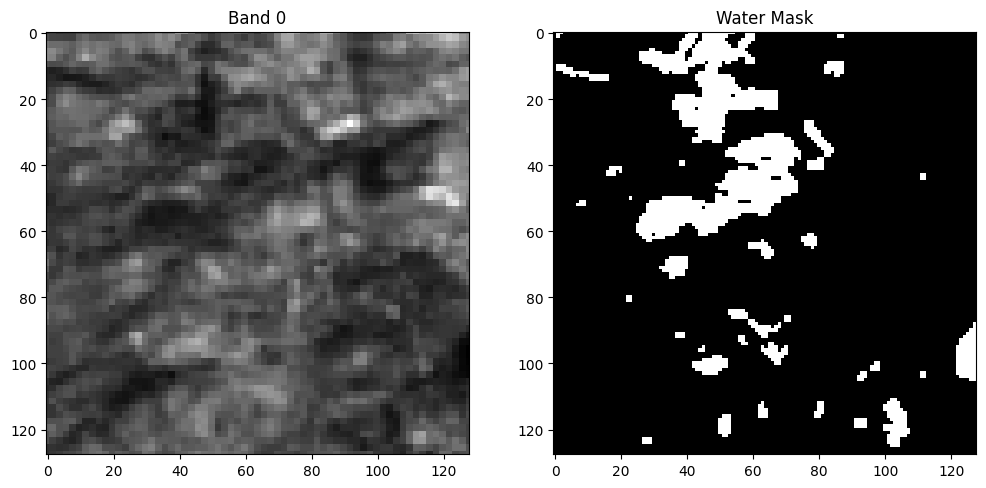

In [113]:
import matplotlib.pyplot as plt

# Function to visualize an image band and label
def visualize_sample(image, label, band_idx=0):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image[..., band_idx], cmap='gray')
    ax[0].set_title(f'Band {band_idx}')
    ax[1].imshow(label[..., 1], cmap='gray')  # Visualize water class
    ax[1].set_title('Water Mask')
    plt.show()

# Visualize the first sample
visualize_sample(images_normalized[0], labels[0][...,1], band_idx=0) # Select the second channel from labels array

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Model
# Define the input shape
input_shape = (128, 128, 12)

# Create an input layer with 12 channels
inputs = Input(shape=input_shape)

# Use a convolutional layer to reduce 12 channels to 3 channels
x = Conv2D(3, (1, 1), padding="same", activation="relu")(inputs)

# Use the EfficientNetB0 backbone
unet_model = Unet(
    backbone_name='efficientnetb0',
    input_shape=(128, 128, 3),  # The EfficientNetB0 expects 3 channels
    classes=2,  # Number of classes for segmentation
    activation='softmax',
    encoder_weights='imagenet'
)(x)


In [115]:
# Define and compile the model
model = Model(inputs=inputs, outputs=unet_model)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(), # Example: Replace with appropriate loss
              metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1]), 'accuracy']) # Example: Replace with appropriate metric
# Print model summary - call summary on the Model object
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 3)         │              39 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, 128, 128, 2)         │      10,115,646 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,115,685 (38.59 MB)

 Trainable params: 10,071,685 (38.42 MB)

 Non-trainable params: 44,000 (171.88 KB)

In [116]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

In [117]:
print(X_train.shape)

(244, 128, 128, 12)


(244, 128, 128, 2, 2)
(244, 128, 128, 2)
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6133 - io_u_1: 0.2500 - loss: 0.7796 - val_accuracy: 0.2250 - val_io_u_1: 0.2500 - val_loss: 2.4847
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7326 - io_u_1: 0.2500 - loss: 0.6415 - val_accuracy: 0.2253 - val_io_u_1: 0.2420 - val_loss: 3.2384
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8013 - io_u_1: 0.2500 - loss: 0.5433 - val_accuracy: 0.2257 - val_io_u_1: 0.1934 - val_loss: 8.1955
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8317 - io_u_1: 0.2500 - loss: 0.4841 - val_accuracy: 0.2469 - val_io_u_1: 0.2022 - val_loss: 7.0365
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8461 - io_u_1: 0.2500 - loss: 0.4483 - val_accuracy: 0.3572 - val_io_u_1: 0.2166 - val_loss: 3.8399
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8654 - io_u_1: 0.2501 - loss: 0.4263 - val_accuracy: 0.4082 - val_io_u_1: 0

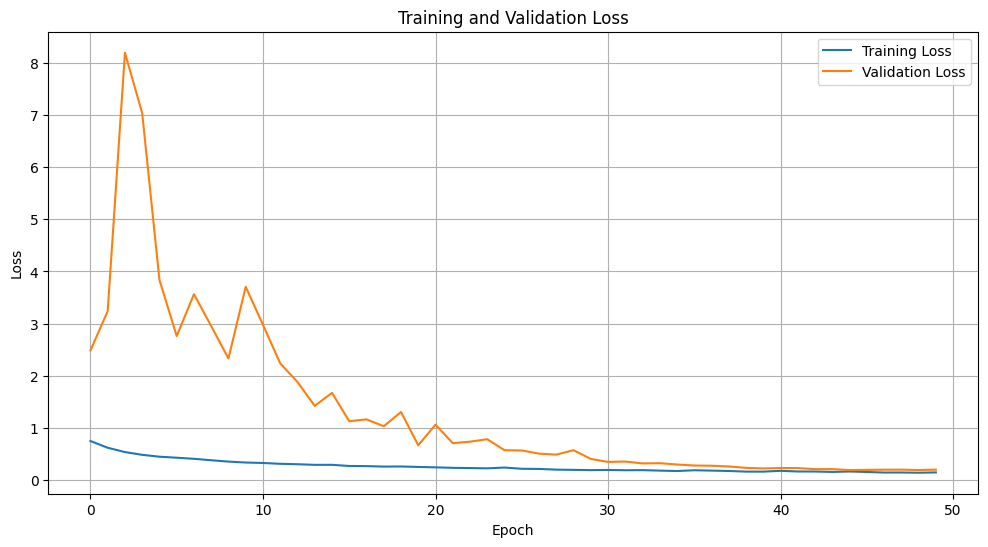

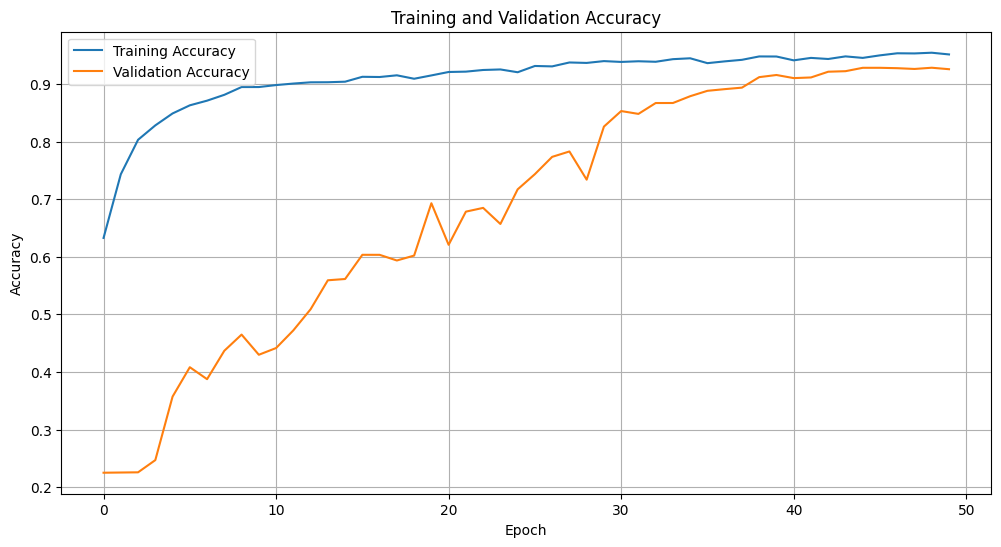

In [118]:
# Check the shape of y_train
print(y_train.shape)

# If y_train has an extra dimension, remove it using slicing
if len(y_train.shape) == 5:
    y_train = y_train[:,:,:,:,0]
    y_val = y_val[:,:,:,:,0]

# Check the shape again to confirm
print(y_train.shape)

# Train the model
history = model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=50,
                         batch_size=16)
# Retrieve loss and metrics from the training history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Check if 'accuracy' is included in history
if 'accuracy' in history_dict:
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# If other metrics are included, plot them as well
metrics = ['iou_score']  # Add any other metrics you are tracking
for metric in metrics:
    if metric in history_dict:
        plt.figure(figsize=(12, 6))
        plt.plot(history_dict[metric], label=f'Training {metric}')
        plt.plot(history_dict[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()


In [119]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_true_argmax = np.argmax(y_val, axis=-1)

# Flatten the predictions and ground truth
y_pred_flat = y_pred_argmax.flatten()
y_true_flat = y_true_argmax.flatten()

# Generate classification report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=['Non-water', 'Water']))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
print("Confusion Matrix:")
print(conf_matrix)

# Compute IoU for each class
def compute_iou(conf_matrix):
    # Confusion matrix should be 2x2 for binary classification
    tn, fp, fn, tp = conf_matrix.ravel()

    iou_background = tp / (tp + fp + fn)
    iou_foreground = tp / (tp + fp + fn)

    return iou_background, iou_foreground

iou_background, iou_foreground = compute_iou(conf_matrix)
print(f'IoU for Non-water class: {iou_background}')
print(f'IoU for Water class: {iou_foreground}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Classification Report:
              precision    recall  f1-score   support

   Non-water       0.92      0.74      0.82    227914
       Water       0.93      0.98      0.95    787894

    accuracy                           0.93   1015808
   macro avg       0.92      0.86      0.89   1015808
weighted avg       0.93      0.93      0.92   1015808

Confusion Matrix:
[[168020  59894]
 [ 15383 772511]]
IoU for Non-water class: 0.9112077547688809
IoU for Water class: 0.9112077547688809


In [120]:
water_segmentation_model_pre_trained = model.save('water_segmentation_model_pre_trained.keras')